In [1]:
# Randomized SVD Experiments: Matrix Compression and Neural Networks
# Implementation of Halko, Martinsson, and Tropp (2010) algorithms

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.linalg import svd, qr
from scipy.fft import fft, ifft
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# ============================================================================
# PART 1: RANDOMIZED SVD ALGORITHMS IMPLEMENTATION
# ============================================================================

class RandomizedSVD:
    """
    Implementation of randomized SVD algorithms from Halko et al. (2010)
    """

    @staticmethod
    def basic_randomized_svd(A: np.ndarray, k: int, p: int = 5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Basic randomized SVD (Algorithm 2 from paper)

        Args:
            A: Input matrix (m x n)
            k: Target rank
            p: Oversampling parameter

        Returns:
            U, S, Vt: SVD factors
        """
        m, n = A.shape
        l = k + p

        # Stage A: Randomized range finding
        Omega = np.random.randn(n, l)
        Y = A @ Omega
        Q, _ = qr(Y, mode='economic')

        # Stage B: Deterministic factorization
        B = Q.T @ A
        U_tilde, S, Vt = svd(B, full_matrices=False)
        U = Q @ U_tilde

        return U[:, :k], S[:k], Vt[:k, :]

    @staticmethod
    def power_iteration_svd(A: np.ndarray, k: int, p: int = 5, q: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Randomized SVD with power iteration (Algorithm 4 from paper)

        Args:
            A: Input matrix (m x n)
            k: Target rank
            p: Oversampling parameter
            q: Number of power iterations

        Returns:
            U, S, Vt: SVD factors
        """
        m, n = A.shape
        l = k + p

        # Stage A: Randomized subspace iteration
        Omega = np.random.randn(n, l)
        Y = A @ Omega

        for _ in range(q):
            Y = A @ (A.T @ Y)

        Q, _ = qr(Y, mode='economic')

        # Stage B: Deterministic factorization
        B = Q.T @ A
        U_tilde, S, Vt = svd(B, full_matrices=False)
        U = Q @ U_tilde

        return U[:, :k], S[:k], Vt[:k, :]
    
    @staticmethod
    def srft_svd(A: np.ndarray, k: int, p: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Subsampled Random Fourier Transform SVD (Algorithm 5 from paper)
        """
        m, n = A.shape
        l = min(k + p, n)  # Ensure l doesn't exceed n

        # Step 1: Create SRFT matrix components
        # D: Random diagonal matrix with ±1 entries
        D = np.random.choice([-1, 1], n)

        # Step 2: Apply SRFT to random Gaussian vectors
        Omega = np.random.randn(n, l)

        # Apply D (diagonal multiplication)
        Omega_D = D[:, np.newaxis] * Omega

        # Apply F (FFT) - take real part for stability
        Omega_DF = np.real(np.fft.fft(Omega_D, axis=0))

        # Apply scaling
        Omega_final = np.sqrt(n/l) * Omega_DF

        # Stage A: Randomized range finding
        Y = A @ Omega_final
        Q, _ = qr(Y, mode='economic')

        # Stage B: Deterministic factorization
        B = Q.T @ A
        U_tilde, S, Vt = svd(B, full_matrices=False)
        U = Q @ U_tilde

        return U[:, :k], S[:k], Vt[:k, :]

    @staticmethod
    def error_estimator(A: np.ndarray, Q: np.ndarray, r: int = 10) -> float:
        """
        Error estimator using Gaussian probes (Section 3.3 from paper)

        Args:
            A: Original matrix
            Q: Orthonormal basis
            r: Number of random probes

        Returns:
            Estimated error
        """
        m, n = A.shape
        errors = []

        for _ in range(r):
            omega = np.random.randn(n)
            residual = A @ omega - Q @ (Q.T @ (A @ omega))
            errors.append(np.linalg.norm(residual))

        return np.sqrt(2/np.pi) * max(errors)

In [3]:
# ============================================================================
# PART 2: SYNTHETIC MATRIX GENERATION
# ============================================================================

def create_fast_decay_matrix(m: int, n: int, decay_rate: float = 0.8) -> np.ndarray:
    """Create matrix with exponentially decaying singular values"""
    k = min(m, n)
    U = np.random.randn(m, k)
    U, _ = qr(U, mode='economic')

    V = np.random.randn(n, k)
    V, _ = qr(V, mode='economic')

    # Exponential decay
    s = np.exp(-decay_rate * np.arange(k))

    return U @ np.diag(s) @ V.T

def create_slow_decay_matrix(m: int, n: int, decay_rate: float = 0.5) -> np.ndarray:
    """Create matrix with polynomially decaying singular values"""
    k = min(m, n)
    U = np.random.randn(m, k)
    U, _ = qr(U, mode='economic')

    V = np.random.randn(n, k)
    V, _ = qr(V, mode='economic')

    # Polynomial decay
    s = 1 / (1 + decay_rate * np.arange(k))

    return U @ np.diag(s) @ V.T

In [4]:
# ============================================================================
# PART 3: EXPERIMENTAL VALIDATION
# ============================================================================

def run_matrix_compression_experiments():
    """Run comprehensive matrix compression experiments"""
    print("\n" + "="*60)
    print("PART 1: MATRIX COMPRESSION EXPERIMENTS")
    print("="*60)

    # Create test matrices
    m, n = 500, 400
    A_fast = create_fast_decay_matrix(m, n, decay_rate=1.0)
    A_slow = create_slow_decay_matrix(m, n, decay_rate=0.3)

    print(f"Created matrices: {m}×{n}")
    print(f"Fast decay matrix condition number: {np.linalg.cond(A_fast):.2e}")
    print(f"Slow decay matrix condition number: {np.linalg.cond(A_slow):.2e}")

    # Test parameters
    ranks = np.arange(5, 101, 5)
    p_values = [5, 10, 20]
    q_values = [0, 1, 2]

    # Initialize results storage
    results = {
        'fast_decay': {'basic': {}, 'power': {}, 'srft': {}, 'deterministic': {}},
        'slow_decay': {'basic': {}, 'power': {}, 'srft': {}, 'deterministic': {}}
    }

    matrices = {'fast_decay': A_fast, 'slow_decay': A_slow}

    for matrix_type, A in matrices.items():
        print(f"\nTesting {matrix_type} matrix...")

        # Get true singular values for comparison
        _, S_true, _ = svd(A, full_matrices=False)

        # Test different methods
        for k in ranks:
            if k >= min(A.shape):
                continue

            # Deterministic SVD baseline
            U_det, S_det, Vt_det = svd(A, full_matrices=False)
            A_det = U_det[:, :k] @ np.diag(S_det[:k]) @ Vt_det[:k, :]
            det_error = np.linalg.norm(A - A_det, 'fro')

            if k not in results[matrix_type]['deterministic']:
                results[matrix_type]['deterministic'][k] = []
            results[matrix_type]['deterministic'][k].append(det_error)

            # Basic randomized SVD
            for p in p_values:
                try:
                    U_basic, S_basic, Vt_basic = RandomizedSVD.basic_randomized_svd(A, k, p)
                    A_basic = U_basic @ np.diag(S_basic) @ Vt_basic
                    basic_error = np.linalg.norm(A - A_basic, 'fro')

                    key = f'p{p}'
                    if key not in results[matrix_type]['basic']:
                        results[matrix_type]['basic'][key] = {}
                    if k not in results[matrix_type]['basic'][key]:
                        results[matrix_type]['basic'][key][k] = []
                    results[matrix_type]['basic'][key][k].append(basic_error)
                except:
                    pass

            # Power iteration
            for q in q_values:
                if q == 0:
                    continue
                try:
                    U_power, S_power, Vt_power = RandomizedSVD.power_iteration_svd(A, k, p=10, q=q)
                    A_power = U_power @ np.diag(S_power) @ Vt_power
                    power_error = np.linalg.norm(A - A_power, 'fro')

                    key = f'q{q}'
                    if key not in results[matrix_type]['power']:
                        results[matrix_type]['power'][key] = {}
                    if k not in results[matrix_type]['power'][key]:
                        results[matrix_type]['power'][key][k] = []
                    results[matrix_type]['power'][key][k].append(power_error)
                except:
                    pass

            # SRFT
            try:
                U_srft, S_srft, Vt_srft = RandomizedSVD.srft_svd(A, k, p=10)
                A_srft = U_srft @ np.diag(S_srft) @ Vt_srft
                srft_error = np.linalg.norm(A - A_srft, 'fro')

                if k not in results[matrix_type]['srft']:
                    results[matrix_type]['srft'][k] = []
                results[matrix_type]['srft'][k].append(srft_error)
            except:
                pass

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    for i, (matrix_type, matrix_results) in enumerate(results.items()):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        # Plot approximation errors
        ranks_plot = sorted([k for k in matrix_results['deterministic'].keys()])

        # Deterministic baseline
        det_errors = [np.mean(matrix_results['deterministic'][k]) for k in ranks_plot]
        ax1.semilogy(ranks_plot, det_errors, 'k-', linewidth=2, label='Deterministic SVD')

        # Basic randomized with different p values
        for p in p_values:
            key = f'p{p}'
            if key in matrix_results['basic']:
                errors = [np.mean(matrix_results['basic'][key][k]) if k in matrix_results['basic'][key] else np.nan
                         for k in ranks_plot]
                ax1.semilogy(ranks_plot, errors, '--', alpha=0.7, label=f'Basic (p={p})')

        # Power iteration
        for q in q_values:
            if q == 0:
                continue
            key = f'q{q}'
            if key in matrix_results['power']:
                errors = [np.mean(matrix_results['power'][key][k]) if k in matrix_results['power'][key] else np.nan
                         for k in ranks_plot]
                ax1.semilogy(ranks_plot, errors, ':', alpha=0.7, label=f'Power (q={q})')

        # SRFT
        srft_errors = [np.mean(matrix_results['srft'][k]) if k in matrix_results['srft'] else np.nan
                      for k in ranks_plot]
        ax1.semilogy(ranks_plot, srft_errors, '-.', alpha=0.7, label='SRFT')

        ax1.set_xlabel('Rank k')
        ax1.set_ylabel('Frobenius Error')
        ax1.set_title(f'{matrix_type.replace("_", " ").title()} Matrix')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot singular value decay
        A = matrices[matrix_type]
        _, S, _ = svd(A, full_matrices=False)
        ax2.semilogy(range(1, len(S[:50])+1), S[:50], 'b-', linewidth=2)
        ax2.set_xlabel('Index')
        ax2.set_ylabel('Singular Value')
        ax2.set_title(f'{matrix_type.replace("_", " ").title()} - Singular Value Decay')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Test error estimators
    print("\nTesting error estimators...")
    A = A_fast
    k = 20
    p = 10

    # Get randomized approximation
    U, S, Vt = RandomizedSVD.basic_randomized_svd(A, k, p)
    Q = U  # Orthonormal basis

    # True error
    A_approx = U @ np.diag(S) @ Vt
    true_error = np.linalg.norm(A - A_approx, 'fro')

    # Estimated error
    estimated_error = RandomizedSVD.error_estimator(A, Q, r=10)

    print(f"True approximation error: {true_error:.6f}")
    print(f"Estimated error: {estimated_error:.6f}")
    print(f"Ratio (estimated/true): {estimated_error/true_error:.2f}")

    return results

In [5]:
# ============================================================================
# PART 4: NEURAL NETWORK COMPRESSION
# ============================================================================

class CompressibleMLP(nn.Module):
    """MLP with compressible weight matrices"""

    def __init__(self, input_size=784, hidden_sizes=[512, 256], num_classes=10):
        super().__init__()

        sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()

        for i in range(len(sizes) - 1):
            self.layers.append(nn.Linear(sizes[i], sizes[i+1]))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:  # No activation after last layer
                x = F.relu(x)
        return x

    def compress_weights(self, compression_rank, method='basic', **kwargs):
        """Compress all weight matrices using randomized SVD"""
        compressed_params = {}
        approximation_errors = {}

        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() == 2:
                W = param.data.numpy()

                if method == 'basic':
                    p = kwargs.get('p', 5)
                    U, S, Vt = RandomizedSVD.basic_randomized_svd(W, compression_rank, p)
                elif method == 'power':
                    p = kwargs.get('p', 5)
                    q = kwargs.get('q', 1)
                    U, S, Vt = RandomizedSVD.power_iteration_svd(W, compression_rank, p, q)
                elif method == 'srft':
                    p = kwargs.get('p', 10)
                    U, S, Vt = RandomizedSVD.srft_svd(W, compression_rank, p)
                elif method == 'deterministic':
                    U_full, S_full, Vt_full = svd(W, full_matrices=False)
                    U, S, Vt = U_full[:, :compression_rank], S_full[:compression_rank], Vt_full[:compression_rank, :]

                # Compute approximation
                W_approx = U @ np.diag(S) @ Vt

                # Store results
                compressed_params[name] = torch.tensor(W_approx, dtype=param.dtype)
                approximation_errors[name] = np.linalg.norm(W - W_approx, 'fro') / np.linalg.norm(W, 'fro')

        return compressed_params, approximation_errors

In [6]:
def train_model(model, train_loader, test_loader, epochs=5):
    """Train the MLP model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    return model

In [7]:
def evaluate_model(model, test_loader):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

In [8]:
def run_neural_network_experiments():
    """Run neural network compression experiments"""
    print("\n" + "="*60)
    print("PART 2: NEURAL NETWORK COMPRESSION EXPERIMENTS")
    print("="*60)

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    print("MNIST dataset loaded successfully")

    # Create and train model
    model = CompressibleMLP(input_size=784, hidden_sizes=[512, 256], num_classes=10)
    print(f"Model architecture: {[layer.weight.shape for layer in model.layers]}")

    # Train the model
    print("\nTraining model...")
    model = train_model(model, train_loader, test_loader, epochs=3)

    # Evaluate original model
    original_accuracy = evaluate_model(model, test_loader)
    print(f"Original model accuracy: {original_accuracy:.2f}%")

    # Compression experiments
    compression_ranks = [10, 20, 50, 100, 150]
    methods = ['basic', 'power', 'srft', 'deterministic']

    results = {method: {'ranks': [], 'accuracies': [], 'errors': []} for method in methods}

    for rank in compression_ranks:
        if rank >= min(model.layers[0].weight.shape):
            continue

        print(f"\nTesting compression rank: {rank}")

        for method in methods:
            print(f"  Method: {method}")

            # Create a copy of the model
            model_copy = CompressibleMLP(input_size=784, hidden_sizes=[512, 256], num_classes=10)
            model_copy.load_state_dict(model.state_dict())

            # Compress weights
            kwargs = {'p': 10, 'q': 1} if method == 'power' else {'p': 10}
            compressed_params, approximation_errors = model_copy.compress_weights(rank, method, **kwargs)

            # Apply compressed weights
            with torch.no_grad():
                for name, param in model_copy.named_parameters():
                    if name in compressed_params:
                        param.copy_(compressed_params[name])

            # Evaluate compressed model
            compressed_accuracy = evaluate_model(model_copy, test_loader)
            avg_error = np.mean(list(approximation_errors.values()))

            results[method]['ranks'].append(rank)
            results[method]['accuracies'].append(compressed_accuracy)
            results[method]['errors'].append(avg_error)

            print(f"    Accuracy: {compressed_accuracy:.2f}%, Avg Error: {avg_error:.4f}")

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot accuracy vs rank
    ax1 = axes[0]
    for method in methods:
        if results[method]['ranks']:
            ax1.plot(results[method]['ranks'], results[method]['accuracies'],
                    'o-', label=method.title(), alpha=0.7)

    ax1.axhline(y=original_accuracy, color='red', linestyle='--',
                label=f'Original ({original_accuracy:.1f}%)')
    ax1.set_xlabel('Compression Rank')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.set_title('Neural Network Compression: Accuracy vs Rank')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot approximation error vs rank
    ax2 = axes[1]
    for method in methods:
        if results[method]['ranks']:
            ax2.semilogy(results[method]['ranks'], results[method]['errors'],
                        'o-', label=method.title(), alpha=0.7)

    ax2.set_xlabel('Compression Rank')
    ax2.set_ylabel('Average Approximation Error')
    ax2.set_title('Neural Network Compression: Approximation Error vs Rank')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Detailed analysis for best performing method
    print("\nDetailed Analysis:")
    print("-" * 40)

    for method in methods:
        if results[method]['ranks']:
            best_idx = np.argmax(results[method]['accuracies'])
            best_rank = results[method]['ranks'][best_idx]
            best_accuracy = results[method]['accuracies'][best_idx]
            best_error = results[method]['errors'][best_idx]

            print(f"{method.title():>12}: Best rank={best_rank:3d}, "
                  f"Accuracy={best_accuracy:5.2f}%, Error={best_error:.4f}")

    return results


PART 1: MATRIX COMPRESSION EXPERIMENTS
Created matrices: 500×400
Fast decay matrix condition number: 1.41e+18
Slow decay matrix condition number: 1.21e+02

Testing fast_decay matrix...

Testing slow_decay matrix...


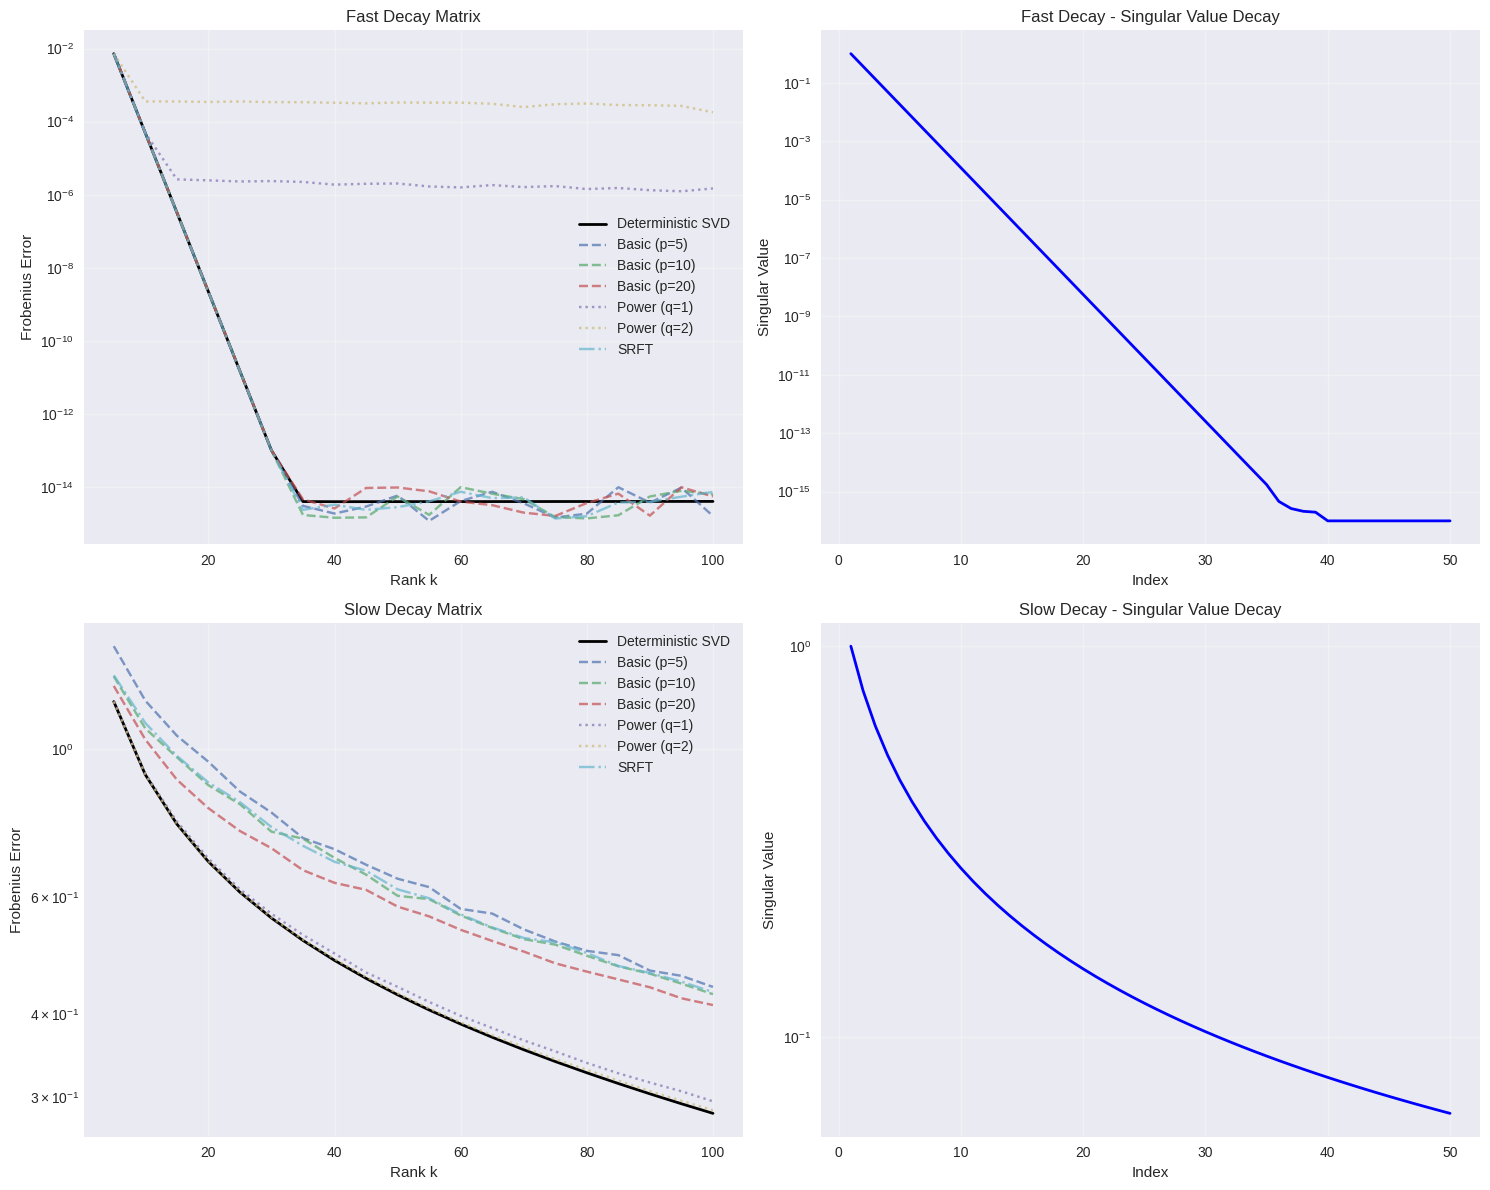


Testing error estimators...
True approximation error: 0.000000
Estimated error: 0.000000
Ratio (estimated/true): 1.04

PART 2: NEURAL NETWORK COMPRESSION EXPERIMENTS
MNIST dataset loaded successfully
Model architecture: [torch.Size([512, 784]), torch.Size([256, 512]), torch.Size([10, 256])]

Training model...
Epoch 1/3, Batch 0, Loss: 2.2887
Epoch 1/3, Batch 200, Loss: 0.2249
Epoch 1/3, Batch 400, Loss: 0.2177
Epoch 1/3, Batch 600, Loss: 0.1559
Epoch 1/3, Batch 800, Loss: 0.0050
Epoch 2/3, Batch 0, Loss: 0.0526
Epoch 2/3, Batch 200, Loss: 0.0234
Epoch 2/3, Batch 400, Loss: 0.0415
Epoch 2/3, Batch 600, Loss: 0.1364
Epoch 2/3, Batch 800, Loss: 0.1200
Epoch 3/3, Batch 0, Loss: 0.0095
Epoch 3/3, Batch 200, Loss: 0.0339
Epoch 3/3, Batch 400, Loss: 0.3697
Epoch 3/3, Batch 600, Loss: 0.0101
Epoch 3/3, Batch 800, Loss: 0.1393
Original model accuracy: 97.22%

Testing compression rank: 10
  Method: basic
    Accuracy: 40.01%, Avg Error: 0.5642
  Method: power
    Accuracy: 65.63%, Avg Error: 0.

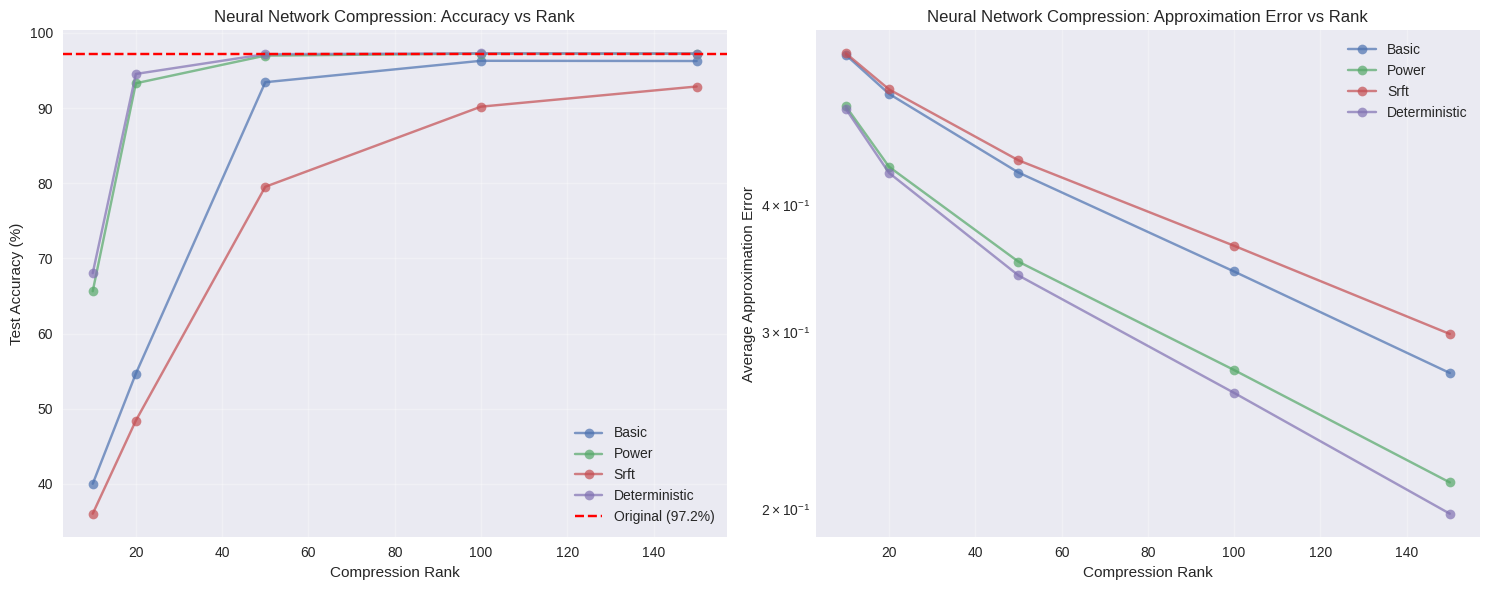


Detailed Analysis:
----------------------------------------
       Basic: Best rank=100, Accuracy=96.28%, Error=0.3442
       Power: Best rank=100, Accuracy=97.24%, Error=0.2749
        Srft: Best rank=150, Accuracy=92.86%, Error=0.2984
Deterministic: Best rank=100, Accuracy=97.27%, Error=0.2609



In [9]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run matrix compression experiments
    matrix_results = run_matrix_compression_experiments()

    # Run neural network compression experiments
    nn_results = run_neural_network_experiments()

    print("\n" + "="*60)

In [10]:
def run_neural_network_compression_with_retraining():
    """Run neural network compression experiments with retraining"""
    print("\n" + "="*60)
    print("NEURAL NETWORK COMPRESSION WITH RETRAINING EXPERIMENTS")
    print("="*60)

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    print("MNIST dataset loaded successfully")

    # Create and train original model
    model = CompressibleMLP(input_size=784, hidden_sizes=[512, 256], num_classes=10)
    print(f"Model architecture: {[layer.weight.shape for layer in model.layers]}")

    # Train the original model
    print("\nTraining original model...")
    model = train_model(model, train_loader, test_loader, epochs=5)

    # Evaluate original model
    original_accuracy = evaluate_model(model, test_loader)
    print(f"Original model accuracy: {original_accuracy:.2f}%")

    # Compression and retraining experiments
    compression_ranks = [10, 20, 50, 100, 150]
    methods = ['basic', 'power', 'srft', 'deterministic']
    retraining_epochs = [0, 1, 3, 5]  # 0 = no retraining

    # Results storage
    results = {}
    for method in methods:
        results[method] = {}
        for epochs in retraining_epochs:
            results[method][f'epochs_{epochs}'] = {
                'ranks': [], 'accuracies': [], 'errors': [], 'accuracy_recovery': []
            }

    print(f"\nTesting compression ranks: {compression_ranks}")
    print(f"Retraining epochs: {retraining_epochs}")

    for rank in compression_ranks:
        if rank >= min(model.layers[0].weight.shape):
            continue

        print(f"\n{'='*40}")
        print(f"Testing compression rank: {rank}")
        print(f"{'='*40}")

        for method in methods:
            print(f"\nMethod: {method.upper()}")
            print("-" * 30)

            # Create a copy of the original model for this method
            base_model = CompressibleMLP(input_size=784, hidden_sizes=[512, 256], num_classes=10)
            base_model.load_state_dict(model.state_dict())

            # Compress weights
            kwargs = {'p': 10, 'q': 1} if method == 'power' else {'p': 10}
            compressed_params, approximation_errors = base_model.compress_weights(rank, method, **kwargs)

            # Apply compressed weights to base model
            with torch.no_grad():
                for name, param in base_model.named_parameters():
                    if name in compressed_params:
                        param.copy_(compressed_params[name])

            # Test different retraining epochs
            for retrain_epochs in retraining_epochs:
                print(f"  Retraining epochs: {retrain_epochs}")
                
                # Create a fresh copy for this retraining experiment
                model_copy = CompressibleMLP(input_size=784, hidden_sizes=[512, 256], num_classes=10)
                model_copy.load_state_dict(base_model.state_dict())

                if retrain_epochs > 0:
                    # Retrain the compressed model
                    print(f"    Retraining for {retrain_epochs} epochs...")
                    
                    # Use a smaller learning rate for fine-tuning
                    criterion = nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model_copy.parameters(), lr=0.0005)
                    
                    model_copy.train()
                    for epoch in range(retrain_epochs):
                        epoch_loss = 0
                        batch_count = 0
                        
                        for batch_idx, (data, target) in enumerate(train_loader):
                            optimizer.zero_grad()
                            output = model_copy(data)
                            loss = criterion(output, target)
                            loss.backward()
                            optimizer.step()
                            epoch_loss += loss.item()
                            batch_count += 1

                            # Print progress less frequently during retraining
                            if batch_idx % 400 == 0:
                                print(f"      Epoch {epoch+1}/{retrain_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
                        
                        avg_epoch_loss = epoch_loss / batch_count
                        print(f"      Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")

                # Evaluate the model
                compressed_accuracy = evaluate_model(model_copy, test_loader)
                avg_error = np.mean(list(approximation_errors.values()))
                accuracy_recovery = (compressed_accuracy - evaluate_model(base_model, test_loader)) if retrain_epochs > 0 else 0

                # Store results
                key = f'epochs_{retrain_epochs}'
                results[method][key]['ranks'].append(rank)
                results[method][key]['accuracies'].append(compressed_accuracy)
                results[method][key]['errors'].append(avg_error)
                results[method][key]['accuracy_recovery'].append(accuracy_recovery)

                print(f"    Accuracy: {compressed_accuracy:.2f}% (Recovery: +{accuracy_recovery:.2f}%)")

    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Accuracy vs Rank for different methods (no retraining)
    ax1 = axes[0, 0]
    for method in methods:
        if results[method]['epochs_0']['ranks']:
            ax1.plot(results[method]['epochs_0']['ranks'], 
                    results[method]['epochs_0']['accuracies'],
                    'o-', label=method.title(), alpha=0.7, markersize=6)

    ax1.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2,
                label=f'Original ({original_accuracy:.1f}%)')
    ax1.set_xlabel('Compression Rank', fontsize=12)
    ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax1.set_title('Compression Without Retraining', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Effect of retraining epochs (using best method)
    ax2 = axes[0, 1]
    best_method = 'deterministic'  # Usually performs best
    
    for epochs in retraining_epochs:
        key = f'epochs_{epochs}'
        if results[best_method][key]['ranks']:
            label = 'No Retraining' if epochs == 0 else f'{epochs} Epochs'
            ax2.plot(results[best_method][key]['ranks'], 
                    results[best_method][key]['accuracies'],
                    'o-', label=label, alpha=0.7, markersize=6)

    ax2.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2,
                label=f'Original ({original_accuracy:.1f}%)')
    ax2.set_xlabel('Compression Rank', fontsize=12)
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax2.set_title(f'Effect of Retraining ({best_method.title()} SVD)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Accuracy recovery from retraining
    ax3 = axes[1, 0]
    for method in methods:
        for epochs in retraining_epochs[1:]:  # Skip 0 epochs
            key = f'epochs_{epochs}'
            if results[method][key]['ranks']:
                ax3.plot(results[method][key]['ranks'], 
                        results[method][key]['accuracy_recovery'],
                        'o-', alpha=0.7, markersize=4,
                        label=f'{method.title()}-{epochs}ep')

    ax3.set_xlabel('Compression Rank', fontsize=12)
    ax3.set_ylabel('Accuracy Recovery (%)', fontsize=12)
    ax3.set_title('Accuracy Recovery from Retraining', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Plot 4: Compression ratio vs final accuracy
    ax4 = axes[1, 1]
    
    # Calculate compression ratios
    original_params = sum(layer.weight.numel() for layer in model.layers)
    
    for method in methods:
        for epochs in [0, 5]:  # Compare no retraining vs max retraining
            key = f'epochs_{epochs}'
            if results[method][key]['ranks']:
                compression_ratios = []
                accuracies = results[method][key]['accuracies']
                
                for rank in results[method][key]['ranks']:
                    # Approximate compressed parameters (U + S + V storage)
                    compressed_params = 0
                    for layer in model.layers:
                        if layer.weight.dim() == 2:
                            m, n = layer.weight.shape
                            compressed_params += rank * (m + n + 1)  # U + Vt + S
                        else:
                            compressed_params += layer.weight.numel()  # Bias terms
                    
                    compression_ratio = compressed_params / original_params
                    compression_ratios.append(compression_ratio)
                
                marker = 'o' if epochs == 0 else 's'
                alpha = 0.6 if epochs == 0 else 0.8
                label = f'{method.title()}-{"No retrain" if epochs == 0 else "5ep retrain"}'
                
                ax4.plot(compression_ratios, accuracies, marker, 
                        alpha=alpha, markersize=6, label=label)

    ax4.axhline(y=original_accuracy, color='red', linestyle='--', linewidth=2,
                label=f'Original')
    ax4.set_xlabel('Compression Ratio', fontsize=12)
    ax4.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax4.set_title('Compression Ratio vs Accuracy', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=8, ncol=2)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n" + "="*80)
    print("DETAILED ANALYSIS")
    print("="*80)
    
    print(f"Original model accuracy: {original_accuracy:.2f}%")
    print(f"Original model parameters: {original_params:,}")
    
    print("\nBest Results by Method (Rank 50):")
    print("-" * 60)
    
    target_rank = 50
    for method in methods:
        print(f"\n{method.upper()}")
        for epochs in retraining_epochs:
            key = f'epochs_{epochs}'
            if target_rank in results[method][key]['ranks']:
                idx = results[method][key]['ranks'].index(target_rank)
                accuracy = results[method][key]['accuracies'][idx]
                recovery = results[method][key]['accuracy_recovery'][idx]
                
                print(f"  {epochs} epochs: {accuracy:5.2f}% (recovery: +{recovery:4.2f}%)")

    # Find best overall result
    best_accuracy = 0
    best_config = None
    
    for method in methods:
        for epochs in retraining_epochs:
            key = f'epochs_{epochs}'
            if results[method][key]['accuracies']:
                max_acc = max(results[method][key]['accuracies'])
                if max_acc > best_accuracy:
                    best_accuracy = max_acc
                    idx = results[method][key]['accuracies'].index(max_acc)
                    rank = results[method][key]['ranks'][idx]
                    best_config = (method, epochs, rank, max_acc)

    if best_config:
        method, epochs, rank, accuracy = best_config
        print(f"\nBest Overall Result:")
        print(f"Method: {method.title()}, Rank: {rank}, Retraining: {epochs} epochs")
        print(f"Accuracy: {accuracy:.2f}% (vs {original_accuracy:.2f}% original)")
        
        # Calculate compression ratio for best result
        compressed_params = 0
        for layer in model.layers:
            if layer.weight.dim() == 2:
                m, n = layer.weight.shape
                compressed_params += rank * (m + n + 1)
            else:
                compressed_params += layer.weight.numel()
        
        compression_ratio = compressed_params / original_params
        print(f"Compression ratio: {compression_ratio:.3f} ({100*(1-compression_ratio):.1f}% reduction)")

    return results


NEURAL NETWORK COMPRESSION WITH RETRAINING EXPERIMENTS
MNIST dataset loaded successfully
Model architecture: [torch.Size([512, 784]), torch.Size([256, 512]), torch.Size([10, 256])]

Training original model...
Epoch 1/5, Batch 0, Loss: 2.2866
Epoch 1/5, Batch 200, Loss: 0.2902
Epoch 1/5, Batch 400, Loss: 0.4443
Epoch 1/5, Batch 600, Loss: 0.0985
Epoch 1/5, Batch 800, Loss: 0.0917
Epoch 2/5, Batch 0, Loss: 0.1234
Epoch 2/5, Batch 200, Loss: 0.0206
Epoch 2/5, Batch 400, Loss: 0.0100
Epoch 2/5, Batch 600, Loss: 0.1288
Epoch 2/5, Batch 800, Loss: 0.0604
Epoch 3/5, Batch 0, Loss: 0.0527
Epoch 3/5, Batch 200, Loss: 0.0736
Epoch 3/5, Batch 400, Loss: 0.0477
Epoch 3/5, Batch 600, Loss: 0.0261
Epoch 3/5, Batch 800, Loss: 0.0253
Epoch 4/5, Batch 0, Loss: 0.0174
Epoch 4/5, Batch 200, Loss: 0.0122
Epoch 4/5, Batch 400, Loss: 0.0067
Epoch 4/5, Batch 600, Loss: 0.0662
Epoch 4/5, Batch 800, Loss: 0.0562
Epoch 5/5, Batch 0, Loss: 0.0035
Epoch 5/5, Batch 200, Loss: 0.0996
Epoch 5/5, Batch 400, Loss: 0.

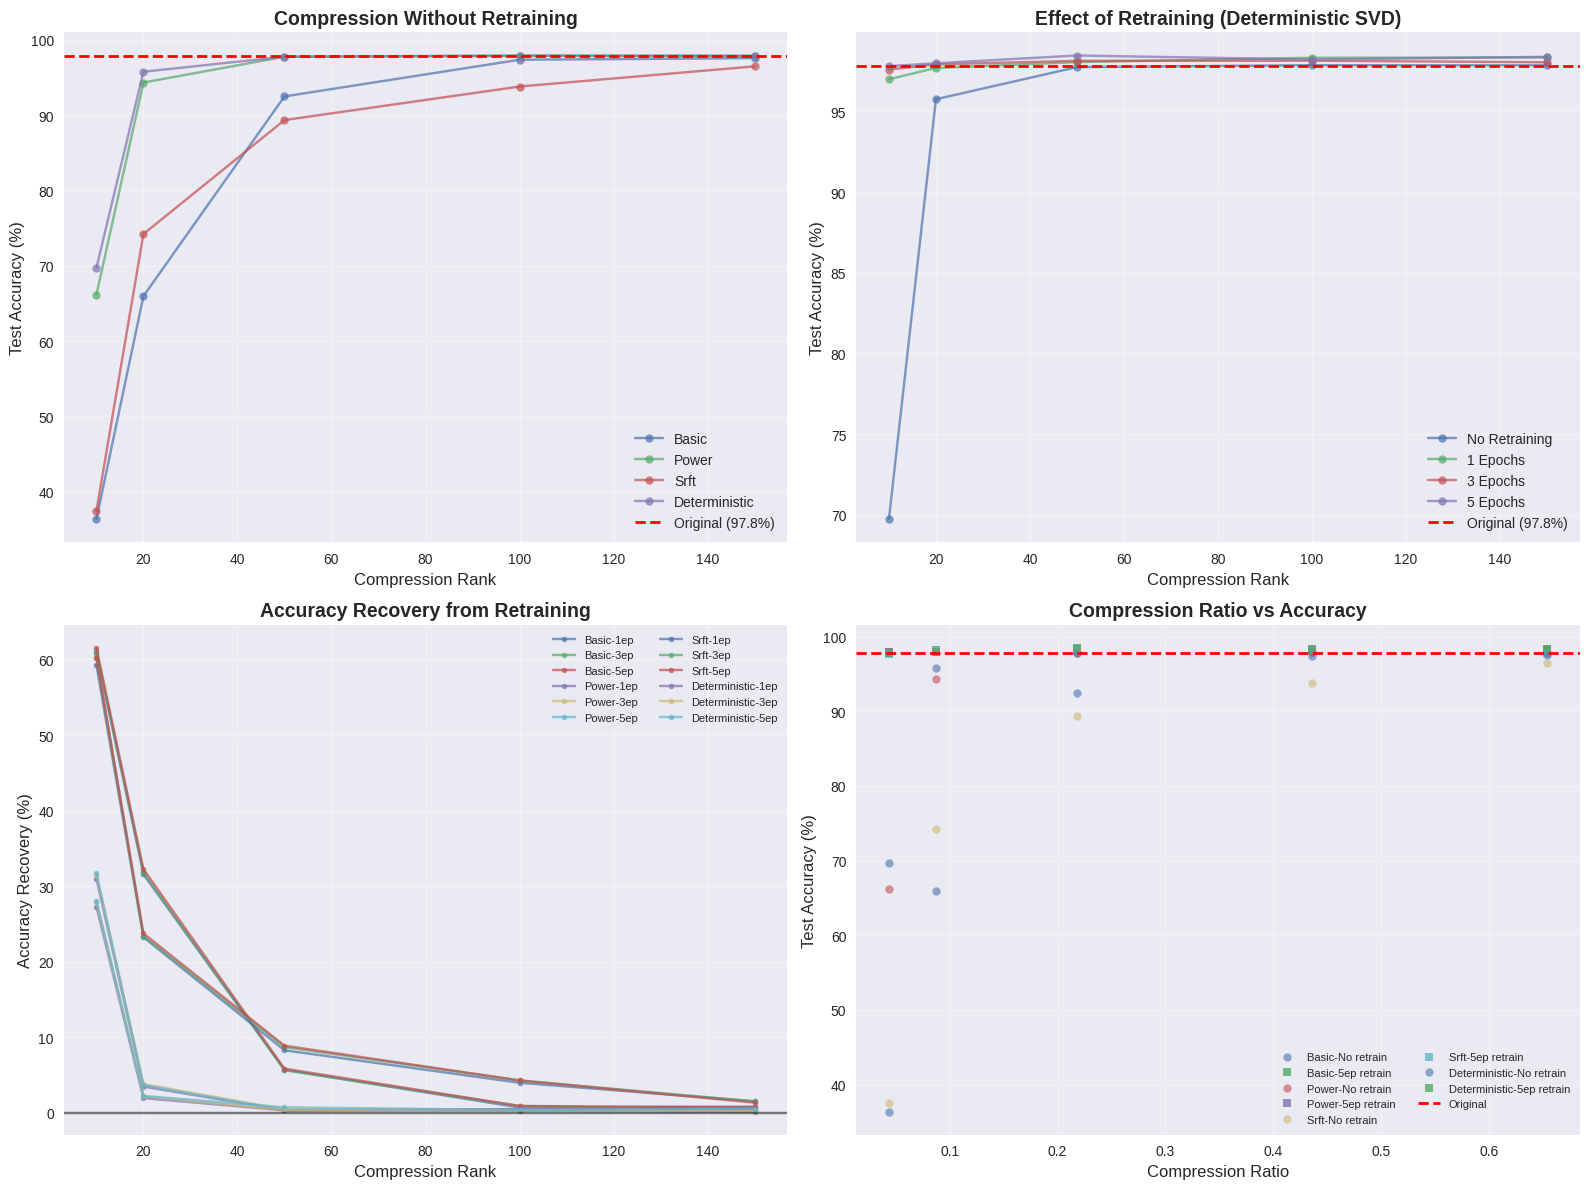


DETAILED ANALYSIS
Original model accuracy: 97.81%
Original model parameters: 535,040

Best Results by Method (Rank 50):
------------------------------------------------------------

BASIC
  0 epochs: 92.48% (recovery: +0.00%)
  1 epochs: 98.18% (recovery: +5.70%)
  3 epochs: 98.11% (recovery: +5.63%)
  5 epochs: 98.32% (recovery: +5.84%)

POWER
  0 epochs: 97.75% (recovery: +0.00%)
  1 epochs: 98.09% (recovery: +0.34%)
  3 epochs: 98.20% (recovery: +0.45%)
  5 epochs: 98.05% (recovery: +0.30%)

SRFT
  0 epochs: 89.34% (recovery: +0.00%)
  1 epochs: 97.61% (recovery: +8.27%)
  3 epochs: 98.04% (recovery: +8.70%)
  5 epochs: 98.22% (recovery: +8.88%)

DETERMINISTIC
  0 epochs: 97.75% (recovery: +0.00%)
  1 epochs: 98.06% (recovery: +0.31%)
  3 epochs: 98.14% (recovery: +0.39%)
  5 epochs: 98.47% (recovery: +0.72%)

Best Overall Result:
Method: Deterministic, Rank: 50, Retraining: 5 epochs
Accuracy: 98.47% (vs 97.81% original)
Compression ratio: 0.218 (78.2% reduction)


{'basic': {'epochs_0': {'ranks': [10, 20, 50, 100, 150],
   'accuracies': [36.38, 65.97, 92.48, 97.35, 97.56],
   'errors': [np.float64(0.5574467883302913),
    np.float64(0.5039968716186329),
    np.float64(0.4181625179675546),
    np.float64(0.3216300879360246),
    np.float64(0.2520957674514224)],
   'accuracy_recovery': [0, 0, 0, 0, 0]},
  'epochs_1': {'ranks': [10, 20, 50, 100, 150],
   'accuracies': [97.26, 97.53, 98.18, 98.04, 98.37],
   'errors': [np.float64(0.5574467883302913),
    np.float64(0.5039968716186329),
    np.float64(0.4181625179675546),
    np.float64(0.3216300879360246),
    np.float64(0.2520957674514224)],
   'accuracy_recovery': [60.88,
    31.560000000000002,
    5.700000000000003,
    0.6900000000000119,
    0.8100000000000023]},
  'epochs_3': {'ranks': [10, 20, 50, 100, 150],
   'accuracies': [97.56, 97.8, 98.11, 98.24, 98.0],
   'errors': [np.float64(0.5574467883302913),
    np.float64(0.5039968716186329),
    np.float64(0.4181625179675546),
    np.float64(0

In [11]:
run_neural_network_compression_with_retraining()